fatal: destination path 'Computervision' already exists and is not an empty directory.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 957ms/step - accuracy: 0.2862 - loss: 1.3210 - val_accuracy: 0.5000 - val_loss: 0.9040
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5435 - loss: 1.0199 - val_accuracy: 0.5000 - val_loss: 0.9074
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6060 - loss: 0.6724 - val_accuracy: 0.5000 - val_loss: 0.7774
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.3375 - loss: 0.9704 - val_accuracy: 0.5000 - val_loss: 0.7803
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5353 - loss: 0.9765 - val_accuracy: 0.3333 - val_loss: 0.7083
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5353 - loss: 0.6639 - val_accuracy: 0.3333 - val_loss: 0.6807
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.5562 - loss: 0.8351 - val_accuracy: 0.5000 - val_loss: 0.6795
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6721 - loss: 0.6527 - val_accuracy: 0.5000 - val_loss: 0.8590
Epoch 9/30
2/2 ━━━━━━

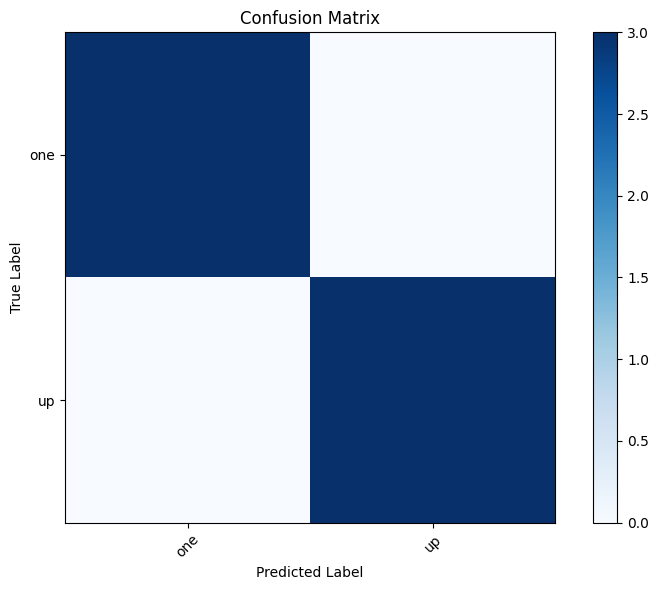

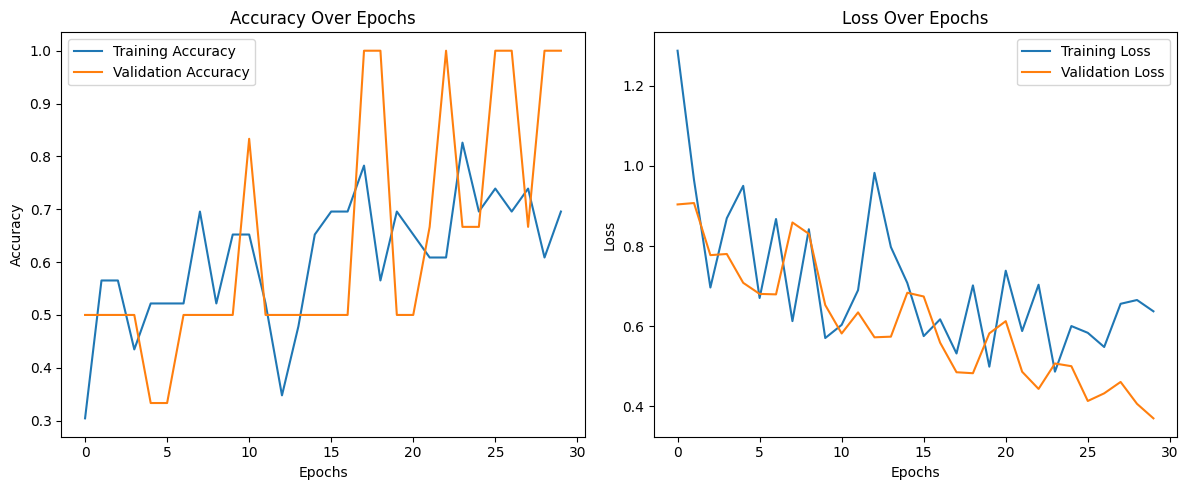

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# GitHub deposunu indir (örneğin Colab'de kullanıyorsanız)
!git clone https://github.com/SevkoHub/Computervision.git

# Dataset yolu
DATASET_PATH = "./Computervision/handgestures"
IMAGE_SIZE = (64, 64)  # Görüntü boyutlandırma

images = []
labels = []

# Görüntüleri yükleyip işleme
for label_name in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_name)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMAGE_SIZE)  # Görüntüyü yeniden boyutlandırma
                images.append(img)
                labels.append(label_name)  # Etiket olarak klasör ismini kullanıyoruz

# Görüntüleri ve etiketleri numpy array'e dönüştürme
images = np.array(images)
labels = np.array(labels)

# Kullanılacak sınıfları seç
selected_classes = ['one', 'up']  # Örnek olarak '1' ve 'Up' sınıflarını seçiyoruz

# Görüntü ve etiketleri filtrele
filtered_images = []
filtered_labels = []

for img, label in zip(images, labels):
    if label in selected_classes:
        filtered_images.append(img)
        filtered_labels.append(label)

# Filtrelenmiş veriyi numpy array'e dönüştür
filtered_images = np.array(filtered_images)
filtered_labels = np.array([selected_classes.index(label) for label in filtered_labels])  # Etiketleri sayısal hale getir

# Veri kontrolü
if len(filtered_images) == 0:
    raise ValueError("Seçilen sınıflar için veri bulunamadı. Lütfen geçerli sınıflar seçin.")

# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(filtered_images, filtered_labels, test_size=0.2, random_state=42)

# Veriyi normalize etme
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes=len(selected_classes))
y_test = to_categorical(y_test, num_classes=len(selected_classes))

# Transfer Learning: VGG16 modeli
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # Önceden eğitilmiş ağırlıkları donduruyoruz

# Transfer learning modelini oluşturma
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Veri artırma
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Modeli eğitme
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=30,
                    validation_data=(X_test, y_test))

# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Precision, Recall ve F1 Score hesaplama
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=selected_classes))

# Confusion matrix görselleştirme
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(selected_classes)), selected_classes, rotation=45)
plt.yticks(np.arange(len(selected_classes)), selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Eğitim ve doğrulama grafikleri
plt.figure(figsize=(12, 5))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
